The following tutorial shows how to implement a learning rate finder from scratch, using Keras callbacks.

But first a quick refresher on how we would do model fitting on a simple network:

## Imports and Data

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import SparseCategoricalCrossentropy

%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(len(x_train), -1)
x_test = x_test.reshape(len(x_test), -1)
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0

11493376/11490434 [==============================] - 0s 0us/step


## Model

In [13]:
model = keras.Sequential()
model.add(keras.layers.Input(x_train.shape[-1]))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [14]:
model.fit(x_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5480 - accuracy: 0.8500
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1601 - accuracy: 0.9546
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1106 - accuracy: 0.9681
Epoch 4/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0817 - accuracy: 0.9773
Epoch 5/5
938/938 [==============================] - 2s 3ms/step - loss: 0.0632 - accuracy: 0.9811


## LR Finder

Let me outline the logic behind LR finder before we dive into the code. The basic idea is to vary the learning rate and note down the loss. At a certain point when the learning rate is too high the loss will start increasing again.

Therefore the tasks that we have to do in order are:
1. Get the minimum and maximum learning rate we are willing to look at.
2. Initialise buffers to hold the learning rate and losses.
3. Before we begin this process, get the current model weights so we can restore it later.
4. Get a batch, and get the loss for that batch, and increase the learning rate.
5. Repeat the above step until maximum learning rate is reached.
6. Reset old weights to model.
7. Plot the model.

The above 7 steps can be seen in the `LRFind` class below. `on_train_begin`, `on_train_batch_end`, `on_train_end` are simply callback functions provided by the keras API. Hopefully, they are self explanatory.

In [15]:
class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

We want to reset the model since it already learnt something decent above, but feel free to skip the next cell to see if results differ.

In [17]:
model = keras.Sequential()
model.add(keras.layers.Input(x_train.shape[-1]))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Before we go ahead and run learning rate finder, a few things we should define. 
- First, we need to use `tf.data.Dataset.from_tensor_slices` incase there aren't enough batches per epoch for learning rate to go from `min_lr` to `max_lr`. 
- We use `EPOCHS=1` but, this is a repeating dataset forever as seen in line 6 below. It is `lr_finder_steps` that force this repetition to stop at 400 batches.
- Instead of `model.fit(x_train, y_train,...)`, we use `model.fit(train_dataset)`.
- When plotting we use the log scale since we increase learning rate multiplicatively.

400/400 [==============================] - 2s 4ms/step - loss: 1.7651 - accuracy: 0.4492


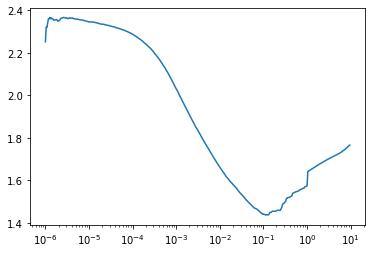

In [22]:
EPOCHS = 1
BATCH_SIZE = 64
lr_finder_steps = 400
lr_find = LRFind(1e-6, 1e1, lr_finder_steps)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))\
                    .repeat()\
                    .shuffle(2048)\
                    .batch(BATCH_SIZE)
model.fit(
    train_dataset,
    steps_per_epoch=lr_finder_steps,
    epochs=EPOCHS,
    callbacks=[lr_find]
)

plt.plot(lr_find.lrs, lr_find.losses)
plt.xscale('log')
plt.show()

So looking at the plot above, the minimum occurs at 0.1, however this is most likely going to be unstable. So a good learning rate to use would be 0.01.

## Shameless Self Promotion
I have a Machine Learning (and Deep Learning) [course on Udemy](https://www.udemy.com/course/machine-learning-and-data-science-2021/?referralCode=E79228C7436D74315787). If you use the code DEEPSCHOOL2021 you can get the course for `$15` instead of the usual `$99`.